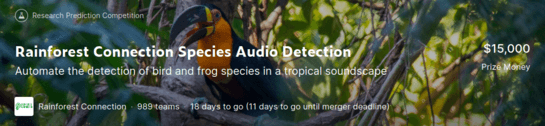

# Introduction

I am new to **audio processing** and have read a lot of things about different Mel transformations and how they are useful as features.

So, as usual, I thought that the best way for me to gain deeper knowledge is to 
share a notebook detailing how the transformation works and why it is useful.

Let's go!

# Prelude: what is an audio signal?

To start, let's have look at one of the audio files. For that, we will use
the `soundfile` library (that comes with `librosa`) to open a `.flac` sample.

In [ ]:
import soundfile as sf
import matplotlib.pyplot as plt
from IPython.display import Audio
%matplotlib inline

In [ ]:
SAMPLE_ID = "1e05620be"
SAMPLE_FILE = f"../input/rfcx-species-audio-detection/train/{SAMPLE_ID}.flac"

In [ ]:
audio_signal, sampling_rate = sf.read(SAMPLE_FILE)

In [ ]:
audio_signal.shape

In [ ]:
sampling_rate

The sampling rate is **48kz.** That means that for each **second**, **48000** samples are captured by the audio recorder (a microphone let's say).

From there, we can deduce the sample length in seconds (i.e. how long is the audio file).

It has **288000** samples and **48000** samples per second as we have mentionnde thus the total duration is:

**2880000 / 48000 = 60s**

We will check this later when playing the audio file. 

Let's display the audio signal now.

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))


ax.set_title("Audio signal for {}")
ax.plot(audio_signal)


Nothing fancy, a varying value roughly between 0.5 and -0.5. You can also listen to the audio clip by pressing the play button below.
I am using the Audio widget to play the file.

In [ ]:
Audio(SAMPLE_FILE)

You can hear some soothing brid songs on a rainforest. Also, the audio signal is indeed **60s** long. All is good.

For the curious: the `.flac` is a loseless audio format (in contrast with MP3 format which is compressed).



Let's zoom in a bit on the signal to see if there are any patterns? We will take a look
at the **2000** first samples.

In [ ]:
fig, ax = plt.subplots(figsize=(20, 10))


ax.set_title(f"Audio signal for {SAMPLE_ID}")
ax.plot(audio_signal[:2000])

So overall, a **mono** audio signal (as any wave function) is one dimensional variation of 
amplitude over time. 

One final thing is sampling depth, i.e. how many different sounds can be recorded.
Usually it is either 16 or 32 bits. In what follows, we won't care much about this 
since the audio signal is represented as a float.

Next, let's see how we can extract features from this audio signal.

# Fourier (and Short-time Fourier) Transform

<img width=400 src="https://upload.wikimedia.org/wikipedia/commons/thumb/5/51/Fourier_unit_pulse.svg/1280px-Fourier_unit_pulse.svg.png">

<center> Example of Fourier transforms from Wikipedia </center>

In any signal that is "wave"-like, the [Fourier transform](https://en.wikipedia.org/wiki/Fourier_transform) is the king of transformations. 

Why so? The answer lays in the nature of the signal that is a superposition of many "fundamentals", i.e. each "fundmental" having a frequency and an amplitude thus we can map the (time, amplitude) space into (frequencey, amplitude) space.


So naturally, we will start with this and see different variations.


To be more precise, we will use the short-time Fourier transform which has two main differences: 

1. Instead of working with an idalized signal, we work with the sampled one (this we will use discrete Fourier transform)

2. Instead of working with the whole time duration at once, we will use overlapping windows (thus the short-time).


Let's apply this transformation using the librosa.stft function.

In [ ]:
import librosa
from librosa.display import specshow
import numpy as np


transformed_audio_signal = librosa.stft(audio_signal)

Let's have a look at the transformed audio signal.

In [ ]:
transformed_audio_signal[0, 0]

In [ ]:
transformed_audio_signal.shape

The transformed signal is a complex number. It has the following shape: 
    
(1025, 5626)

Let's plot the spectre (amplitude and angle)

In [ ]:
fig, ax = plt.subplots(figsize=(15, 3))


transformed_amplitude = librosa.amplitude_to_db(np.abs(transformed_audio_signal) ** 2, 
                                                ref=np.max)

im = specshow(transformed_amplitude, y_axis='log', x_axis='time', ax=ax)

fig.colorbar(im, format='%+2.0f dB')

In [ ]:
fig, ax = plt.subplots(figsize=(15, 3))


transformed_angle = librosa.amplitude_to_db(np.angle(transformed_audio_signal), 
                                                ref=np.max)

im = specshow(transformed_angle, y_axis='log', x_axis='time', ax=ax)

fig.colorbar(im, format='%+2.0f dB')

Let's describe what we are seeing: 

- In the first graph: this is the spectrogram
- In the second spectrogram: this is something similar to the spectrogram but this time with the 
phase of the STFT and not its amplitude.

# Mel Scale

Alright, we have seen that **power spectogram** (via the stft) gives a nice representation that can be useful to extract features.

Can we do better?

The answer is yes. For that we will start with the Mel scale and it will become 
clear why it is useful once I explain what it is.

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))

# How many FFT components are kept?
N_FFT = 2048

mel_scale_signal = librosa.filters.mel(sampling_rate, N_FFT) 

im = specshow(mel_scale_signal, x_axis='linear', ax=ax)

ax.set_ylabel('Mel filter')

ax.set_title('Mel filter bank')

fig.colorbar(im)

fig.tight_layout()



Here are some sound ranges for animals in comparaison: 


    
<img src="https://upload.wikimedia.org/wikipedia/commons/5/5d/Animal_hearing_frequency_range.svg">

# Mel Spectrogram

Once we have introdced the Mel scale, we can now explore some transformations
based on it. 

Let's start with the Mel spectrogram.

In [ ]:

fig, ax = plt.subplots(figsize=(15, 3))

S = librosa.feature.melspectrogram(y=audio_signal, sr=sampling_rate)
S_dB = librosa.power_to_db(S, ref=np.max)


img = librosa.display.specshow(S_dB, x_axis='time', y_axis='mel', sr=sampling_rate,
                               fmax=16000, ax=ax)

fig.colorbar(img, ax=ax, format='%+2.0f dB')

ax.set(title='Mel-frequency spectrogram')

# MFCC

Next, we will compute and plot the **MFCCs**, the big boys of this notebook.

In [ ]:
S = librosa.feature.melspectrogram(y=audio_signal, sr=sampling_rate, n_mels=128, fmax=16000)

mfccs = librosa.feature.mfcc(S=librosa.power_to_db(S))

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))


im = specshow(mfccs, x_axis='time', y_axis='mel', ax=ax, sr=48000,
                             fmax=24000, fmin=40)


fig.colorbar(im, format='%+2.0f dB')


ax.set_title(f'MFCC for {SAMPLE_ID}')


Let's check another MFCCs for another sample. For that, we need to 
assemble previous elements in a function.

In [ ]:
def compute_and_plot_mfccs(sample_id="009b760e6"):
    sample_file = f"../input/rfcx-species-audio-detection/train/{sample_id}.flac"
    audio_signal, sampling_rate = sf.read(sample_file)
    S = librosa.feature.melspectrogram(y=audio_signal, sr=sampling_rate, n_mels=128,
                                       fmax=16000) # 16k is better?

    mfccs = librosa.feature.mfcc(S=librosa.power_to_db(S))
    fig, ax = plt.subplots(figsize=(15, 5))


    mfccs = librosa.feature.mfcc(S=librosa.power_to_db(S))

    im = specshow(mfccs, x_axis='time', y_axis='mel', ax=ax, sr=48000,
                                 fmax=24000, fmin=40)


    fig.colorbar(im, format='%+2.0f dB')


    ax.set_title(f'MFCC for {sample_id}')

In [ ]:
compute_and_plot_mfccs()

We can see that both MFCCs are quite distinct so this will be useful to train a classification model.

In [ ]:
compute_and_plot_mfccs("015aa6c7c")

In [ ]:
compute_and_plot_mfccs("013716dbf")

# The Algorithm

Now that we have all the preliminary ingredients laid out, let's see how the algorithm works.

Here are the main steps (from the Wiki page): 
    
    
1.     Take the Fourier transform of (a windowed excerpt of) a signal.
2.     Map the powers of the spectrum obtained above onto the mel scale, using **triangular overlapping windows**.
3.     Take the logs of the powers at each of the mel frequencies.
4.     Take the discrete cosine transform of the list of mel log powers, as if it were a signal.
5.     The MFCCs are the amplitudes of the resulting spectrum.
    
    
Let's explore each step.

We have already explored the first step.

As for step 2, we have seen the mel scale but not yet how to map the power spectrum 
using the triangular overlapping windows. Let's do this.

## Triangular Overlapping Windows

As its name indicates, it is a particualr [windows function](https://en.wikipedia.org/wiki/Window_function) that has a [triangular shape](https://en.wikipedia.org/wiki/Window_function#Triangular_window), nothing more to that.

Now the interesting part is to divide the frequency space not uniformely as we would do in a spectrogram but using the Mel scale. To achieve this, 
we take the Mel spectre that is a tringuaglar overlopping window family and take the dot product with the FFT of the audio signal.

## Log scale

This is the easiest step, we take the **log** (or more preciesly the **[decibel](https://en.wikipedia.org/wiki/Decibel)**) of each power component.

This is achieved in librosa using [power_to_db](https://librosa.org/doc/main/generated/librosa.power_to_db.html?highlight=power_to_db) function for example.

## Discrete Cosine Transform

This is the final step.

Another transform you might ask? How is it defined? Why is it useful?

Let's start with the definition. Will it is one of the many possible definitions, DCT I: 


<img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/be8dacb1e78120e504f6fa9d98757c5fc1cd8f89">

As its name indicates, we transform the sampled original signal using modulated cosines.
It is closely related to DFT but with only real values and only using cosines.


Alright, you might ask now: okay, for what?


One possible explanation is that DCT is useful to "de-correlate" the signal, i.e. parts of a signal that are very close or similar will be 
mapped to more distinct parts. This isn't very precise but this is the best I have found. :p

This final step is achieved using  [scipy.fftpack.dct](https://docs.scipy.org/doc/scipy/reference/generated/scipy.fftpack.dct.html) function and using DCT II by default.

To recap: **MFCCs** are obtained by transforming a spectrum using **DCT** with the **Mel scale**. 

For the curious, the term **cepstrum** in MFCC comes from spectrum with the first 4 letters reversed (ceps <-> spec). This is to show that cepstrum are spectrograms of spectrograms (applying an inverse transform).

That's it for today's notebook. I hope you have enjoyed this short introduction to the Mel-frequency cepstrum (and other related concepts).

In [ ]:
# As a bonus, here are more power spectrograms



def compute_and_plot_power_spectrogram(sample_id="009b760e6"):
    sample_file = f"../input/rfcx-species-audio-detection/train/{sample_id}.flac"
    audio_signal, sampling_rate = sf.read(sample_file)
    transformed_audio_signal = librosa.stft(audio_signal)

    fig, ax = plt.subplots(figsize=(15, 3))


    transformed_amplitude = librosa.amplitude_to_db(np.abs(transformed_audio_signal) ** 2, 
                                                    ref=np.max)

    im = specshow(transformed_amplitude, y_axis='log', x_axis='time', ax=ax)

    fig.colorbar(im, format='%+2.0f dB')

In [ ]:
compute_and_plot_power_spectrogram()

# Resources to go beyond


- A good videdo intro to audio processing for classification: https://www.youtube.com/watch?v=Z7YM-HAz-IY
- A good introduction to many audio processing terms: https://www.vocitec.com/docs-tools/blog/sampling-rates-sample-depths-and-bit-rates-basic-audio-concepts
- STFT wiki page: https://en.wikipedia.org/wiki/Short-time_Fourier_transform
- STFT librosa: http://man.hubwiz.com/docset/LibROSA.docset/Contents/Resources/Documents/generated/librosa.core.stft.html
- Nyquist frequency: https://en.wikipedia.org/wiki/Nyquist_frequency 
- Cepstrum: https://en.wikipedia.org/wiki/Cepstrum
- Mel Scale: https://en.wikipedia.org/wiki/Mel_scale
- A two videos quick introduction to audio processing for classification: https://www.youtube.com/watch?v=Z7YM-HAz-IY and https://www.youtube.com/watch?v=-GddLd2_0ok (lots of similiar topics)
- MFCC: https://stackoverflow.com/questions/1638126/how-to-make-mfcc-algorithm
- Hearing range: https://en.wikipedia.org/wiki/Hearing_range
- DCT: https://en.wikipedia.org/wiki/Discrete_cosine_transform
- FLAC format: https://en.wikipedia.org/wiki/FLAC
- Another good MFCC notebook: https://www.kaggle.com/seriousran/mfcc-feature-extraction-for-sound-classification/data
- Theory heavy wiki page about spectral density:https://en.wikipedia.org/wiki/Spectral_density#Explanation